In [ ]:
#https://www.pyimagesearch.com/2020/10/12/multi-class-object-detection-and-bounding-box-regression-with-keras-tensorflow-and-deep-learning/

In [1]:
# import the necessary packages
import os
# define the base path to the input dataset and then use it to derive
# the path to the input images and annotation CSV files
BASE_PATH = "/home/jupyter/Margot"
IMAGES_PATH = "/home/jupyter/data"
ANNOTS_PATH = BASE_PATH

In [2]:
# define the path to the base output directory
BASE_OUTPUT = "/home/jupyter/Margot/object_detection_tutorial/output"
# define the path to the output model, label binarizer, plots output
# directory, and testing image paths
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "detector.h5"])
LB_PATH = os.path.sep.join([BASE_OUTPUT, "lb.pickle"])
PLOTS_PATH = os.path.sep.join([BASE_OUTPUT, "plots"])
TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_paths.txt"])

In [3]:
# initialize our initial learning rate, number of epochs to train
# for, and the batch size
INIT_LR = 1e-4
NUM_EPOCHS = 20
BATCH_SIZE = 32

In [4]:
# import the necessary packages
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import os
import json

In [5]:
# initialize the list of data (images), class labels, target bounding
# box coordinates, and image paths
print("[INFO] loading dataset...")
data = []
labels = []
bboxes = []
imagePaths = []

[INFO] loading dataset...


In [6]:
%cd /home/jupyter/Margot/
with open('_annotations.json') as json_file: 
    annot = json.load(json_file) 
# loop over all CSV files in the annotations directory
for item in annot['annotations']:
	# break the row into the filename, bounding box coordinates,
	# and class label
    filename = item
    startX = annot['annotations'][item][0]['x']
    startY = annot['annotations'][item][0]['y']
    endX = annot['annotations'][item][0]['x2']
    endY = annot['annotations'][item][0]['y2']
    label = annot['annotations'][item][0]['label']
    # derive the path to the input image, load the image (in
    # OpenCV format), and grab its dimensions
    imagePath = os.path.sep.join([IMAGES_PATH, label, filename])
    image = cv2.imread(imagePath)
    (h, w) = image.shape[:2]
	# scale the bounding box coordinates relative to the spatial
	# dimensions of the input image
    #startX = float(startX) / w
    #startY = float(startY) / h
    #endX = float(endX) / w
    #endY = float(endY) / h
    # load the image and preprocess it
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
	# update our list of data, class labels, bounding boxes, and
	# image paths
    data.append(image)
    labels.append(label)
    bboxes.append((startX, startY, endX, endY))
    imagePaths.append(imagePath)

/home/jupyter/Margot


In [7]:
# convert the data, class labels, bounding boxes, and image paths to
# NumPy arrays, scaling the input pixel intensities from the range
# [0, 255] to [0, 1]
data = np.array(data, dtype="float32") / 255.0
labels = np.array(labels)
bboxes = np.array(bboxes, dtype="float32")
imagePaths = np.array(imagePaths)
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
# only there are only two labels in the dataset, then we need to use
# Keras/TensorFlow's utility function as well
if len(lb.classes_) == 2:
	labels = to_categorical(labels)

In [8]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
split = train_test_split(data, labels, bboxes, imagePaths,
	test_size=0.20, random_state=42)
# unpack the data split
(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:4]
(trainBBoxes, testBBoxes) = split[4:6]
(trainPaths, testPaths) = split[6:]
# write the testing image paths to disk so that we can use then
# when evaluating/testing our object detector
print("[INFO] saving testing image paths...")
f = open(TEST_PATHS, "w")
f.write("\n".join(testPaths))
f.close()

[INFO] saving testing image paths...


In [9]:
tf.debugging.set_log_device_placement(True)
with tf.device('/CPU:0'):
    # load the VGG16 network, ensuring the head FC layers are left off
    vgg = VGG16(weights="imagenet", include_top=False,
        input_tensor=Input(shape=(224, 224, 3)))
    # freeze all VGG layers so they will *not* be updated during the
    # training process
    vgg.trainable = False
    # flatten the max-pooling output of VGG
    flatten = vgg.output
    flatten = Flatten()(flatten)

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
E

In [10]:
tf.debugging.set_log_device_placement(True)
with tf.device('/CPU:0'):
# construct a fully-connected layer header to output the predicted
# bounding box coordinates
    bboxHead = Dense(128, activation="relu")(flatten)
    bboxHead = Dense(64, activation="relu")(bboxHead)
    bboxHead = Dense(32, activation="relu")(bboxHead)
    bboxHead = Dense(4, activation="sigmoid",
        name="bounding_box")(bboxHead)
# construct a second fully-connected layer head, this one to predict
# the class label
softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(512, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(len(lb.classes_), activation="softmax",
	name="class_label")(softmaxHead)
# put together our model which accept an input image and then output
# bounding box coordinates and a class label
model = Model(
	inputs=vgg.input,
	outputs=(bboxHead, softmaxHead))

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
E

In [11]:
# define a dictionary to set the loss methods -- categorical
# cross-entropy for the class label head and mean absolute error
# for the bounding box head
losses = {
	"class_label": "categorical_crossentropy",
	"bounding_box": "mean_squared_error",
}
# define a dictionary that specifies the weights per loss (both the
# class label and bounding box outputs will receive equal weight)
lossWeights = {
	"class_label": 1.0,
	"bounding_box": 1.0
}
# initialize the optimizer, compile the model, and show the model
# summary
opt = Adam(lr=INIT_LR)
model.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=lossWeights)
print(model.summary())

Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
_______________________________________________

In [12]:
# construct a dictionary for our target training outputs
trainTargets = {
	"class_label": trainLabels,
	"bounding_box": trainBBoxes
}
# construct a second dictionary, this one for our target testing
# outputs
testTargets = {
	"class_label": testLabels,
	"bounding_box": testBBoxes
}

In [ ]:
# train the network for bounding box regression and class label
# prediction
print("[INFO] training model...")
H = model.fit(
	trainImages, trainTargets,
	validation_data=(testImages, testTargets),
	batch_size=BATCH_SIZE,
	epochs=NUM_EPOCHS,
	verbose=1)
# serialize the model to disk
print("[INFO] saving object detector model...")
model.save(MODEL_PATH, save_format="h5")
# serialize the label binarizer to disk
print("[INFO] saving label binarizer...")
f = open(LB_PATH, "wb")
f.write(pickle.dumps(lb))
f.close()

[INFO] training model...
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/devi

In [92]:
# plot the total loss, label loss, and bounding box loss
lossNames = ["loss", "class_label_loss", "bounding_box_loss"]
N = np.arange(0, NUM_EPOCHS)
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize=(13, 13))
# loop over the loss names
for (i, l) in enumerate(lossNames):
	# plot the loss for both the training and validation data
	title = "Loss for {}".format(l) if l != "loss" else "Total loss"
	ax[i].set_title(title)
	ax[i].set_xlabel("Epoch #")
	ax[i].set_ylabel("Loss")
	ax[i].plot(N, H.history[l], label=l)
	ax[i].plot(N, H.history["val_" + l], label="val_" + l)
	ax[i].legend()
# save the losses figure and create a new figure for the accuracies
plt.tight_layout()
plotPath = os.path.sep.join([PLOTS_PATH, "losses.png"])
plt.savefig(plotPath)
plt.close()

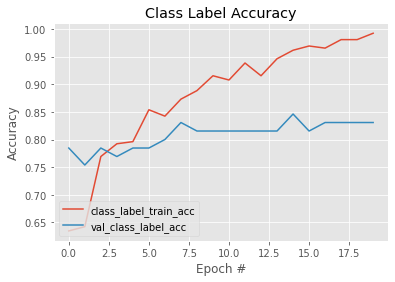

In [93]:
# create a new figure for the accuracies
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["class_label_accuracy"],
	label="class_label_train_acc")
plt.plot(N, H.history["val_class_label_accuracy"],
	label="val_class_label_acc")
plt.title("Class Label Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
# save the accuracies plot
plotPath = os.path.sep.join([PLOTS_PATH, "accs.png"])
plt.savefig(plotPath)

In [61]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
import numpy as np
import mimetypes
import argparse
import pickle
import cv2
import os
import imutils

In [94]:
# single input image
#imagePaths = PATH
# if the file type is a text file, then we need to process *multiple*
# images
# load the image paths in our testing file
imagePaths = open(TEST_PATHS).read().strip().split("\n")

In [95]:
# load our object detector and label binarizer from disk
print("[INFO] loading object detector...")
model = load_model(MODEL_PATH)
lb = pickle.loads(open(LB_PATH, "rb").read())

[INFO] loading object detector...


Good


Good


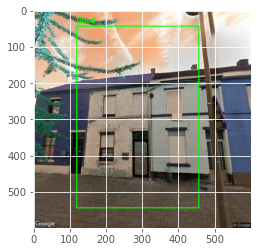

Good


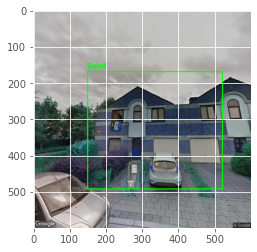

Good


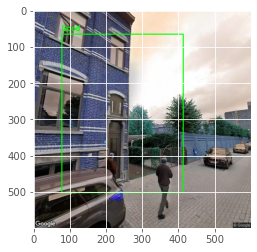

Good


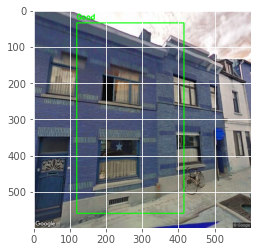

Good


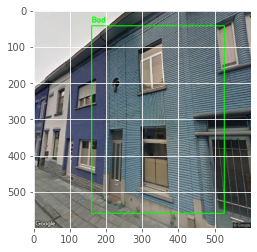

Bad


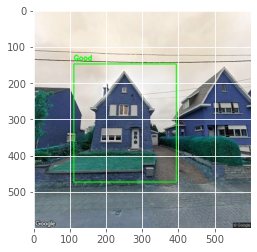

Good


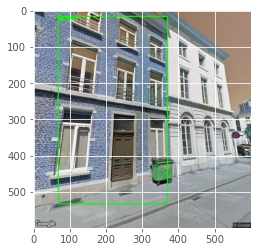

Good


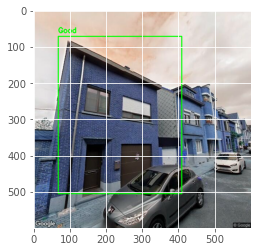

Good


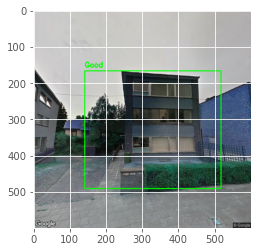

Good


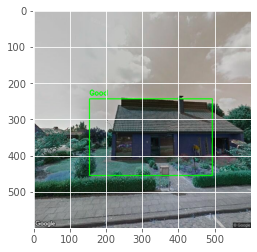

Good


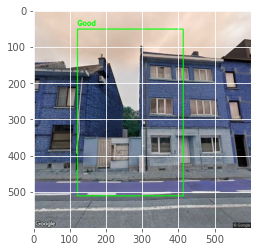

Good


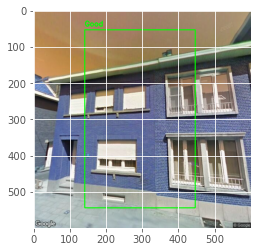

Good


Good


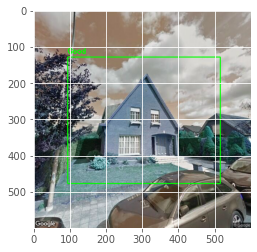

Good


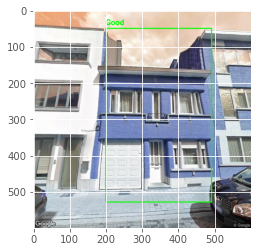

Good


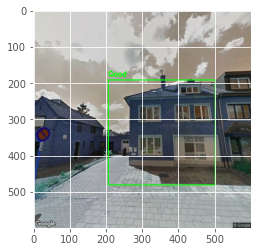

Good


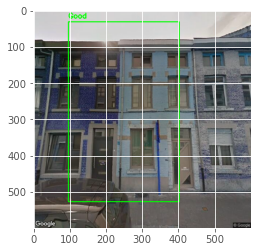

Good


Good


Good


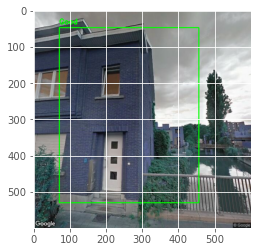

Good


Good


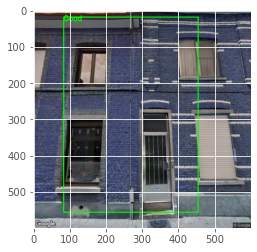

Good


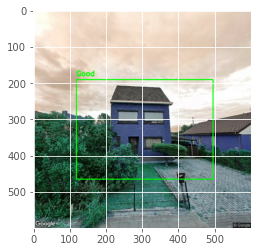

Good


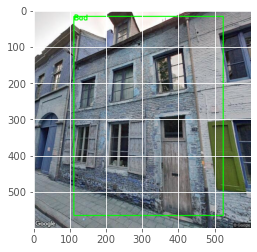

Bad


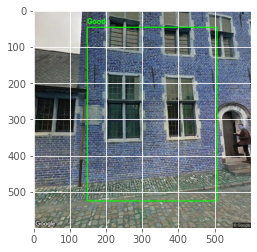

Good


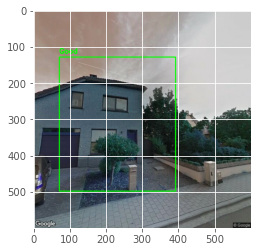

Good


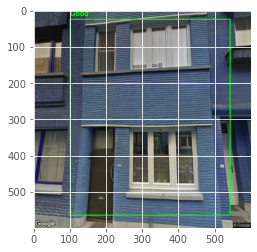

Good


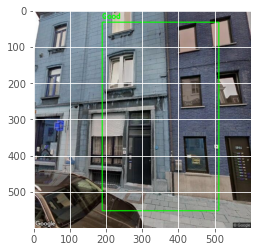

Good


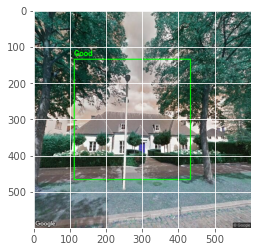

Good


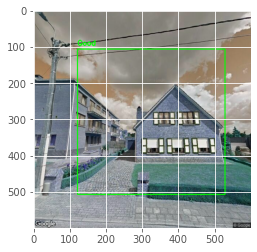

Good


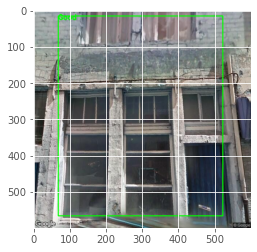

Good


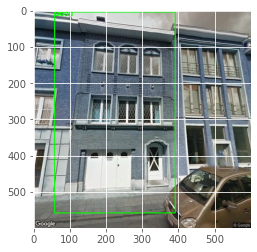

Good


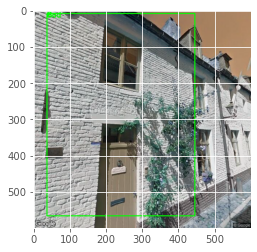

Bad


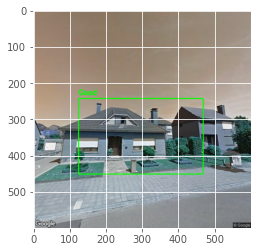

Good


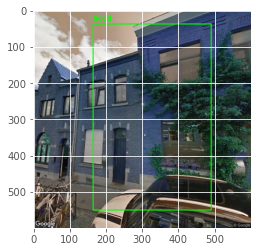

Good


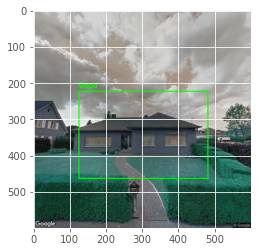

Good


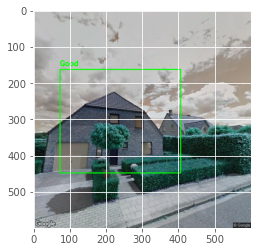

Good


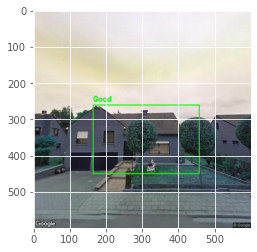

Good


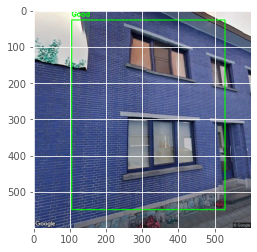

Good


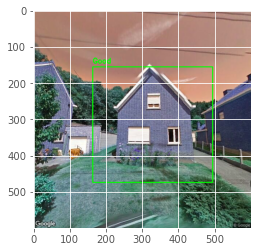

Good


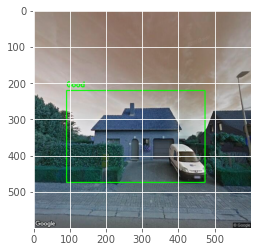

Good


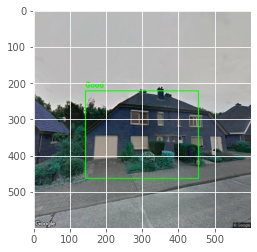

Good


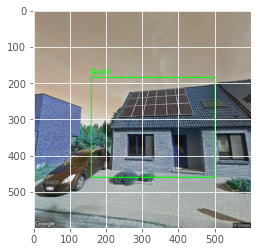

Good


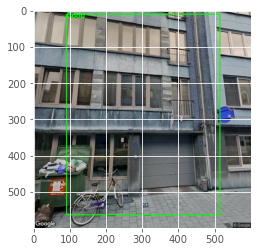

Good


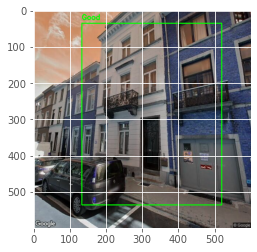

Good


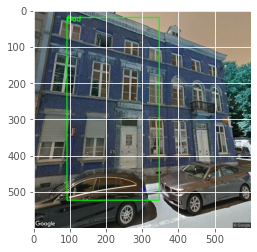

Bad


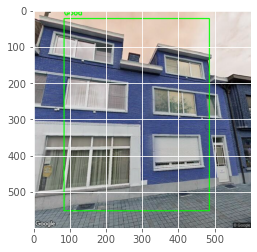

Good


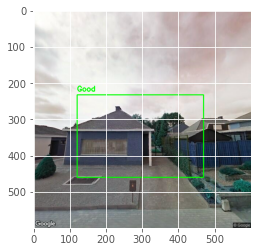

Good


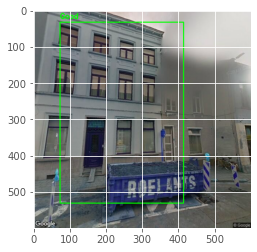

Good


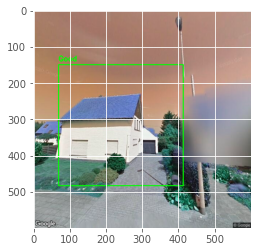

Good


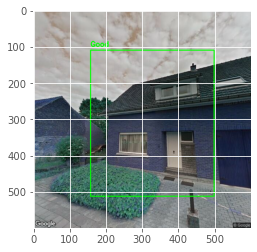

Good


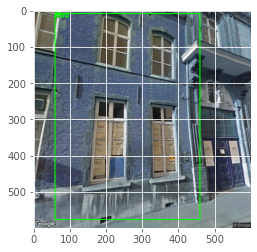

Bad


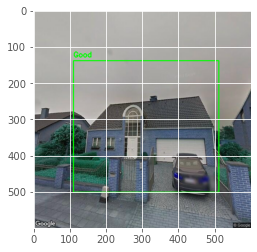

Good


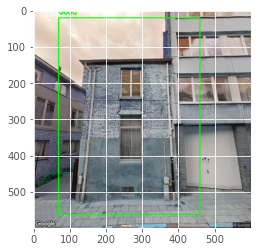

Good


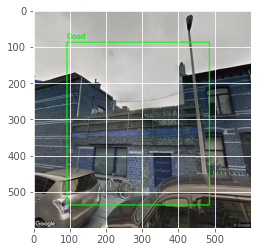

Good


Good


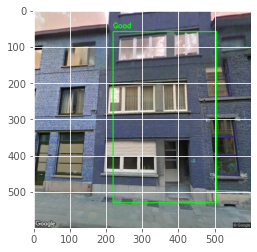

Good


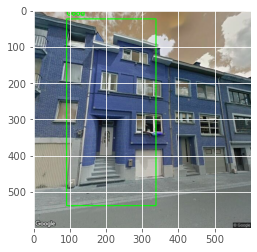

Good


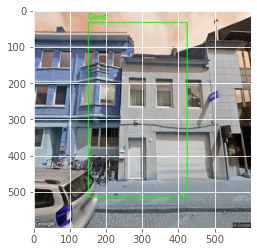

Good


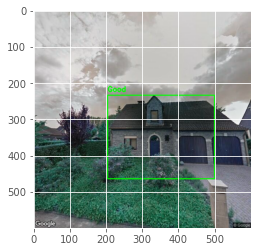

Good


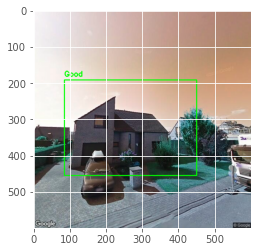

Good


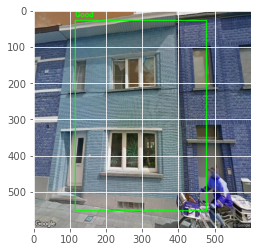

Good


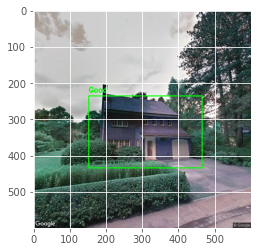

Good


In [100]:
# loop over the images that we'll be testing using our bounding box
# regression model
for imagePath in imagePaths:
	# load the input image (in Keras format) from disk and preprocess
	# it, scaling the pixel intensities to the range [0, 1]
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image) / 255.0
	image = np.expand_dims(image, axis=0)
	# predict the bounding box of the object along with the class
	# label
	(boxPreds, labelPreds) = model.predict(image)
	(startX, startY, endX, endY) = boxPreds[0]
	# determine the class label with the largest predicted
	# probability
	i = np.argmax(labelPreds, axis=1)
	label = lb.classes_[i][0]
    # load the input image (in OpenCV format), resize it such that it
	# fits on our screen, and grab its dimensions
	image = cv2.imread(imagePath)
	image = imutils.resize(image, width=600)
	(h, w) = image.shape[:2]
	# scale the predicted bounding box coordinates based on the image
	# dimensions
	startX = int(startX * w)
	startY = int(startY * h)
	endX = int(endX * w)
	endY = int(endY * h)
	# draw the predicted bounding box and class label on the image
	y = startY - 10 if startY - 10 > 10 else startY + 10
	cv2.putText(image, label, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 255, 0), 2)
	cv2.rectangle(image, (startX, startY), (endX, endY), (0, 255, 0), 2)
	# show the output image
	plt.imshow(image)
	plt.show()
	print(label)

In [104]:
saved_model_path = "/home/jupyter/Margot/object_detection_tutorial/savedmodel"
tf.saved_model.save(model, saved_model_path)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /home/jupyter/Margot/object_detection_tutorial/savedmodel/assets
